In [11]:
### IMPORT SCIENTIFIC LIBRARIES ###
import numpy as np
import pandas as pd
from scipy import sparse
from scipy.optimize import curve_fit
import lmfit as lm
from tqdm import tqdm
from contextlib import redirect_stdout
import io


import matplotlib.pyplot as plt
plt.rcParams['font.size'], plt.rcParams['axes.labelsize'] = 14, 18
import sys, importlib

import sys
sys.path.append('./XPCSlibrary/')

import ID10_tools as ID10
from ID10_tools import Nx, Ny, Npx
importlib.reload(ID10)
ID10.set_version('v2')

import XPCS_tools as XPCS
from XPCS_tools import E2lambda, lambda2E, theta2Q, Q2theta, decorrelation_f
importlib.reload(XPCS)
XPCS.set_beamline('ID10')

import COSMICRAY_tools as COSMIC
importlib.reload(COSMIC)
COSMIC.set_beamline('ID10')

### EXPERIMENTAL VARIABLES ###
XPCS.set_expvar(Nx//2, Ny//2, 5)
ID10.Nfmax_dense_file = 2000
ID10.Nfmax_sparse_file = 5000

from folder_paths import *

## Load masks

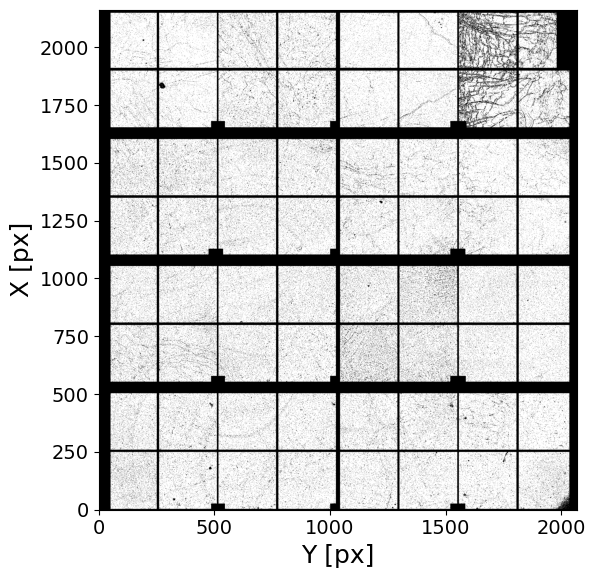

In [12]:
e4m_mask = np.load(MASKS_folder+'e4m_mask'+'.npy')
e4m_htmask = np.load(MASKS_folder+'e4m_htmask_Mo_fluorescence'+'.npy')
mask_geom = np.load(MASKS_folder  + 'mask_geom_1.7delcoup.npy')
e4mht_mask_si = np.load(MASKS_folder  + 'e4m_htmask_Si_substrate.npy')

plt.figure(figsize=(6, 6))
plt.imshow((e4m_mask*e4m_htmask).reshape(Nx,Ny), cmap='gray', origin='lower')
plt.xlabel('Y [px]')
plt.ylabel('X [px]')
plt.tight_layout(); plt.show()

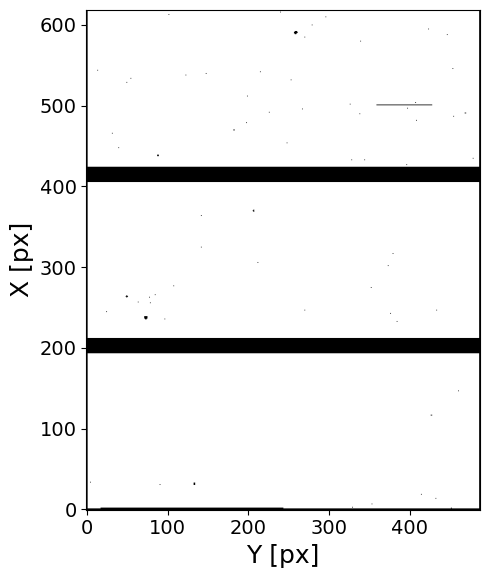

In [13]:
pilatus_mask = np.load(MASKS_folder+'pilatus300k_mask_20240201'+'.npy').astype(bool)

plt.figure(figsize=(6, 6))
plt.imshow(~pilatus_mask, cmap='gray', origin='lower')
plt.xlabel('Y [px]')
plt.ylabel('X [px]')
plt.tight_layout(); plt.show()

## Q mask

In [14]:
###########
Q = 0.33
dq = 0.01
###########
Q=float(Q)

## XPCS scan: delcoup=1.7, T=4h (Si_substrate 1, 5)  

Si film, to study rtole of substrate

#############################
command = mtimescan 0.001 2 86000367
Ei = 21.669991317784486
itime = 0.0011
T =  1.3425551944444445 h
theta = 1.6999999999999993
Qc = 0.33
#############################



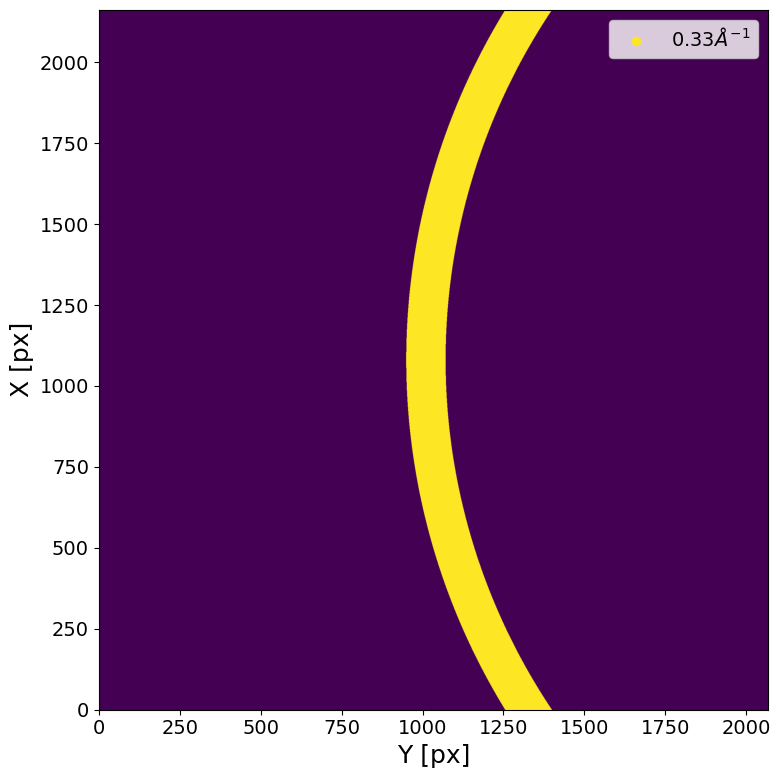

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00008.h5 (9/879 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/879 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00006.h5 (7/879 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/879 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00010.h5 (11/879 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00009.h5 (10/879 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00007.h5 (8/879 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/879 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00005.h5 (6/879 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/879 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00050.h5 (51/879 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/879 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00051.h5 (52/879 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00052.h5 (53/879 loops)
	 -> loading file eiger4m_v2_spa

In [15]:
#######################################
sample_name = 'Si_substrate'
Ndataset =1
Nscan = 4
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
T = scan['fast_timer_period'].size*itime
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('T = ', T/60**2, 'h')
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

#################################################################################
Nfi, Nff = None, None#len(scan['fast_timer_period'])-5001
Q=0.33
Qmask = XPCS.gen_Qmask(Ei, theta, Q, dq, Qmap_plot=False)
load_mask = e4m_mask*e4m_htmask*Qmask*e4mht_mask_si*mask_geom
##################################################################################

e4m_data = ID10.load_sparse_e4m(RAW_folder, sample_name, Ndataset, Nscan, Nfi=Nfi, Nff=Nff, load_mask=load_mask, n_jobs=50, )

### Flux check

################################################################################
Maximum count in the whole run -> 3.0
# of pixels above Ith_high treshold ->  4295894 pixels (of 4471016 => 96.08 %)
# of pixels below Ith_low treshold ->  49 pixels (of 4471016 => 0.0 %)
################################################################################



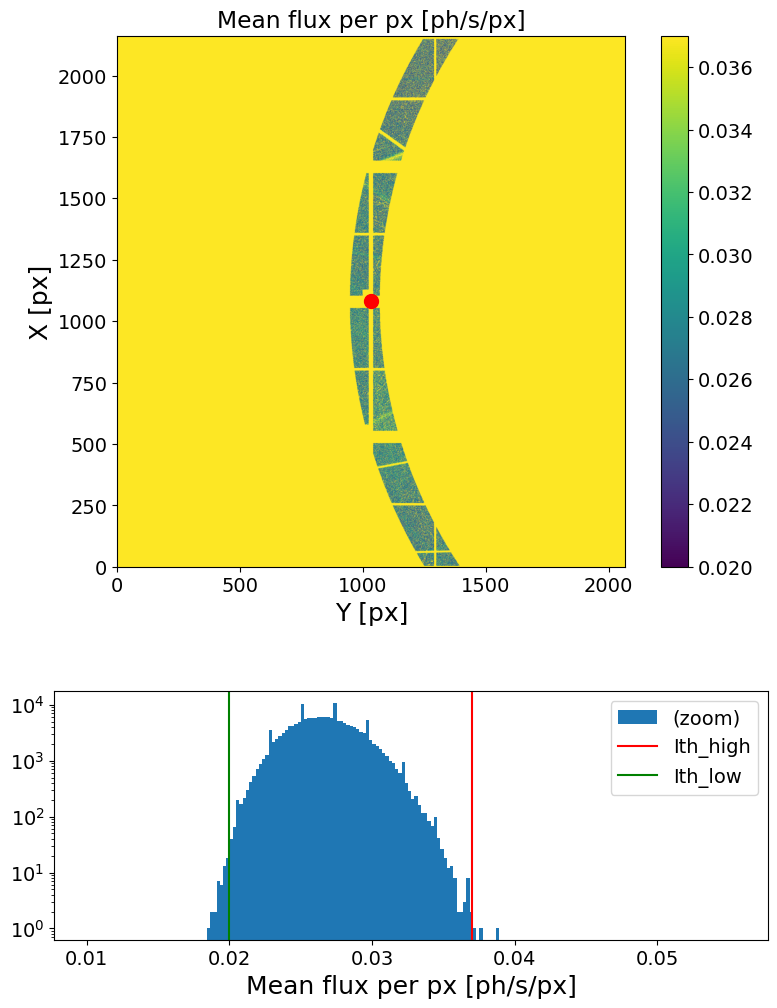

In [16]:
XPCS.gen_plots4mask(e4m_data, itime, Ith_low=0.02, Ith_high=0.037, Nfi=None, Nff=int(1e7), load_mask=load_mask, mask=None)

### Intensity analysis in Q

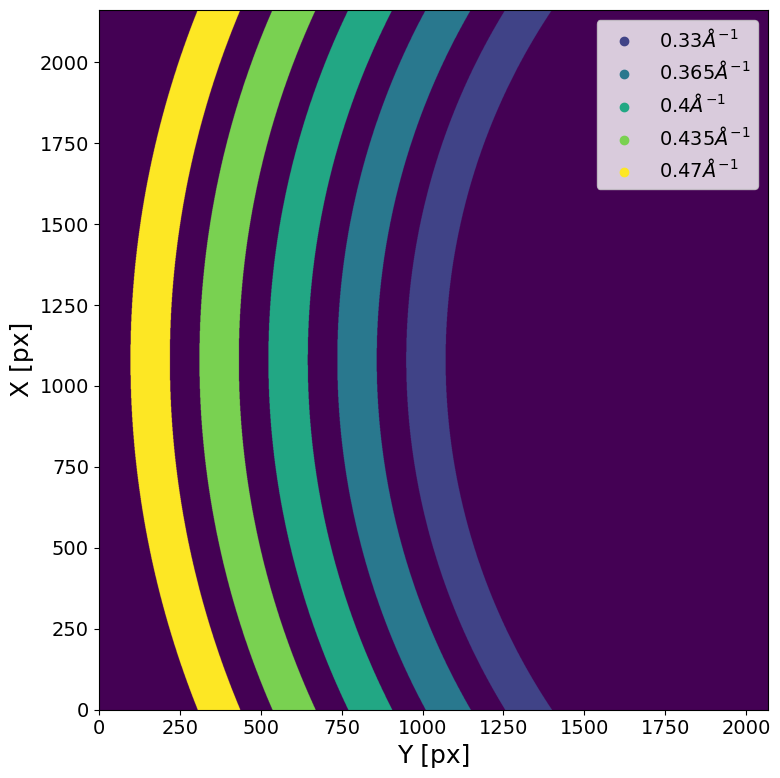

In [9]:
Q = np.linspace(0.33,0.47,5,endpoint=True)
dq = 0.01
Qmask = XPCS.gen_Qmask(Ei, theta, Q, dq, Qmap_plot=False)

#################################################
Masked area =  84.99989711510761 %
#################################################



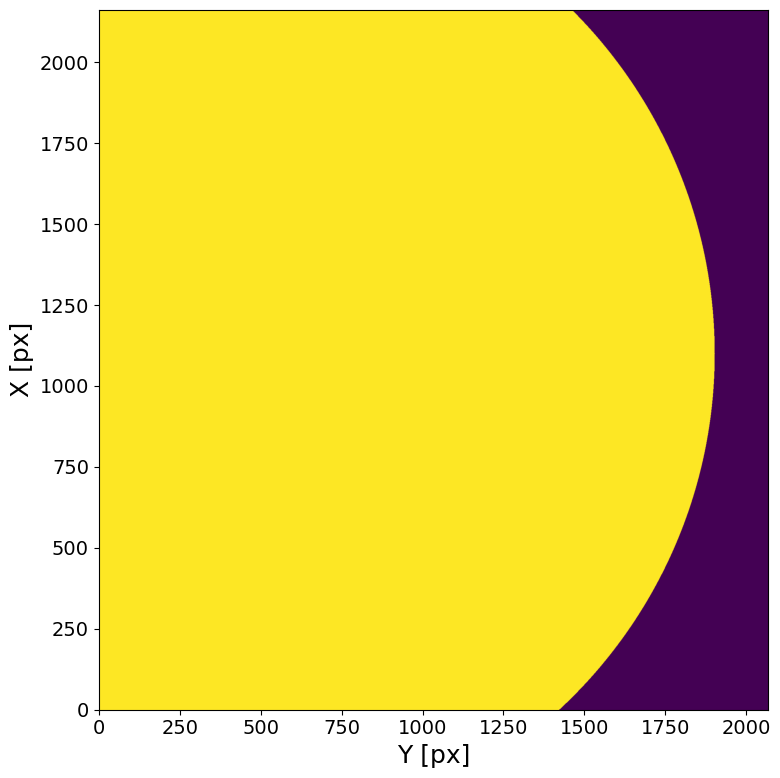

In [23]:
mask_geom_circle = [{'geom' : 'Circle', 'Cx': 1100, 'Cy':400, 'r':1500, 'inside': True}]

mask_geom = XPCS.gen_mask(mask_geom=mask_geom_circle)
np.save(MASKS_folder  + 'mask_geom_1.7delcoup.npy', mask_geom)

In [11]:
##################
Nf_th = 5/6
##################

Ip =      e4m_data[:int(Nf_th*e4m_data.shape[0]) ].sum(axis=0)/(int(Nf_th    *e4m_data.shape[0])*itime)
Ip_test = e4m_data[ int(Nf_th*e4m_data.shape[0]):].sum(axis=0)/(int((1-Nf_th)*e4m_data.shape[0])*itime)

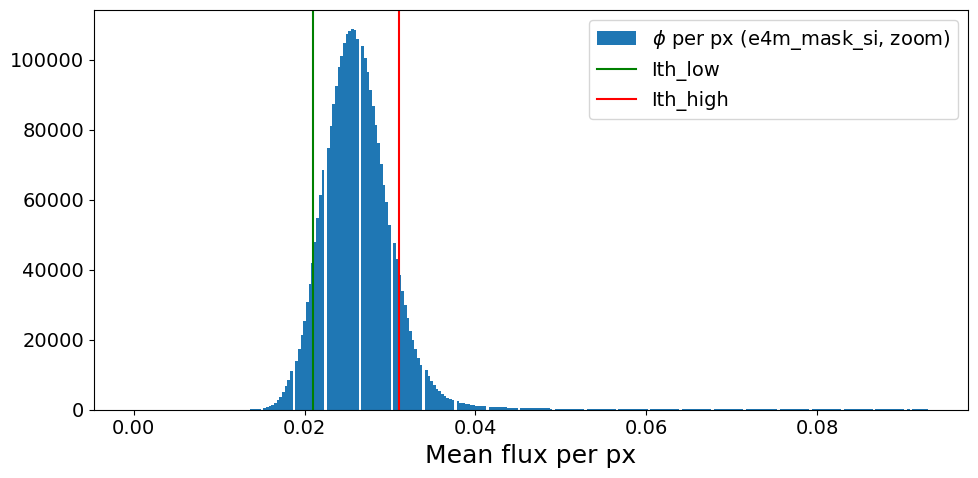

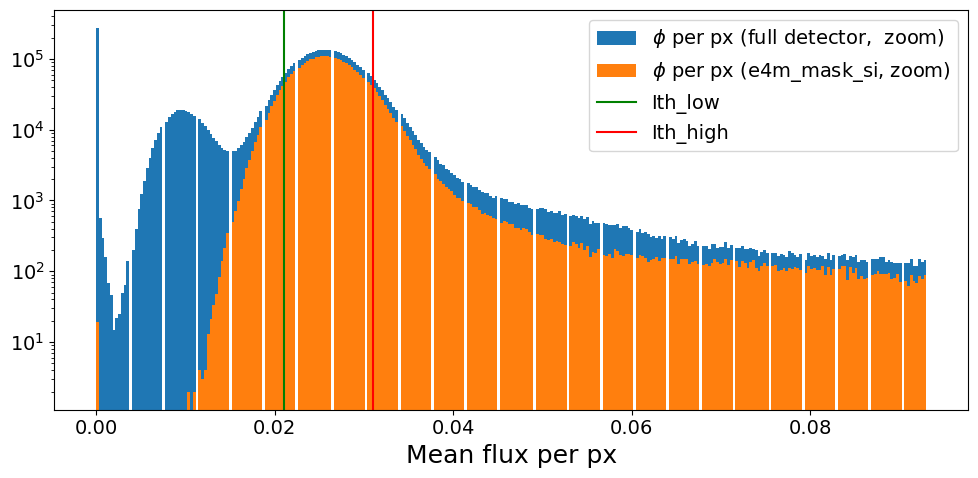

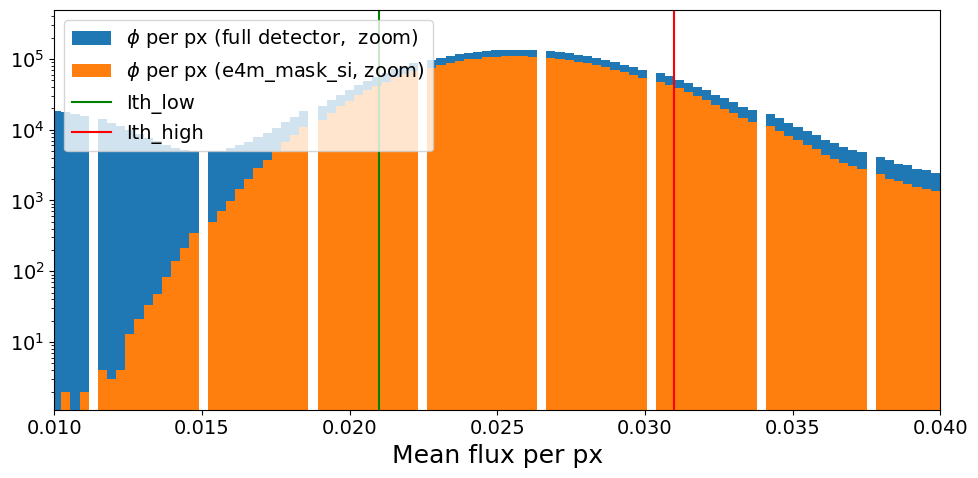

In [14]:
##################################################
e4m_mask_si = e4m_mask*e4m_htmask*mask_geom
Ith_low = 0.021
Ith_high = 0.031
#################################################


plt.figure(figsize=(10, 5))
plt.hist(Ip[e4m_mask_si], bins=300, range=(0, Ith_high*3), label='$\\phi$ per px (e4m_mask_si, zoom)')
plt.axvline(Ith_low, color='g', label='Ith_low')
plt.axvline(Ith_high, color='r', label='Ith_high')
plt.xlabel('Mean flux per px')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(Ip,           bins=300, range=(0, Ith_high*3), label='$\\phi$ per px (full detector,  zoom)')
plt.hist(Ip[e4m_mask_si], bins=300, range=(0, Ith_high*3), label='$\\phi$ per px (e4m_mask_si, zoom)')
plt.axvline(Ith_low, color='g', label='Ith_low')
plt.axvline(Ith_high, color='r', label='Ith_high')
plt.yscale('log')
plt.xlabel('Mean flux per px')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(Ip,           bins=300, range=(0, Ith_high*3), label='$\\phi$ per px (full detector,  zoom)')
plt.hist(Ip[e4m_mask_si], bins=300, range=(0, Ith_high*3), label='$\\phi$ per px (e4m_mask_si, zoom)')
plt.axvline(Ith_low, color='g', label='Ith_low')
plt.axvline(Ith_high, color='r', label='Ith_high')
plt.yscale('log')
plt.xlabel('Mean flux per px')
plt.legend()
plt.xlim(.01, .04)
plt.tight_layout()
plt.show()





#### Higher trehsold map

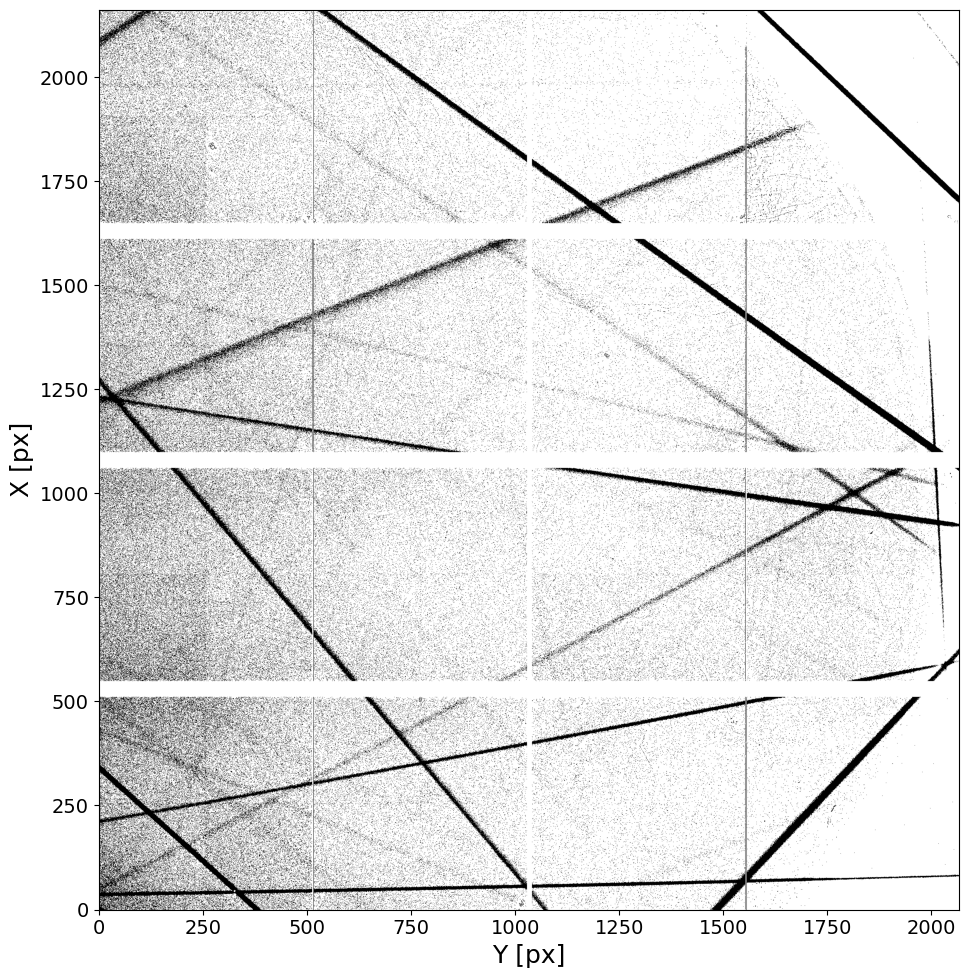

In [15]:
plt.figure(figsize=(10, 10))
plt.imshow(~(Ip>Ith_high).reshape(Nx, Ny), cmap='gray', origin='lower', alpha=1)
plt.xlabel('Y [px]')
plt.ylabel('X [px]')
plt.tight_layout()
plt.show()

#### Lower threshold map

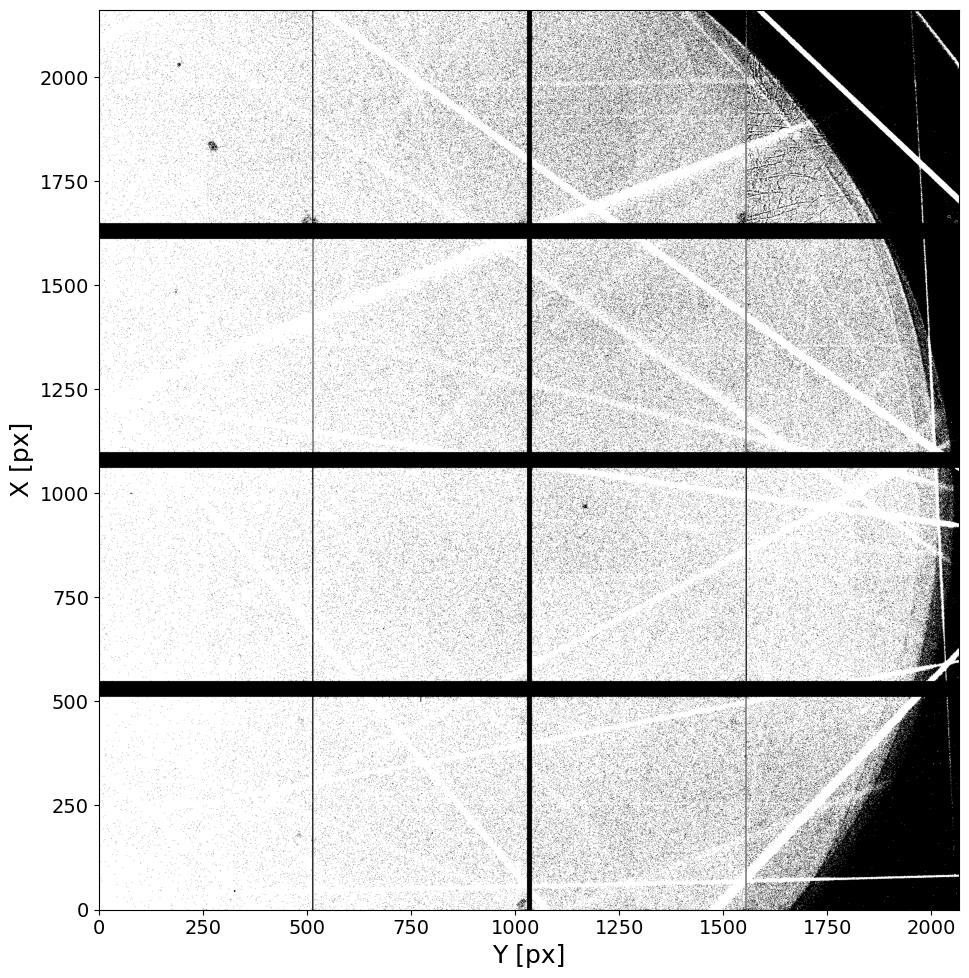

In [16]:
plt.figure(figsize=(10, 10))
plt.imshow(~(Ip<Ith_low).reshape(Nx, Ny), cmap='gray', origin='lower', alpha=1)
plt.xlabel('Y [px]')
plt.ylabel('X [px]')
plt.tight_layout()
plt.show()

In [17]:
e4mht_mask_si = (Ip>Ith_low) * (Ip<Ith_high)
np.save(MASKS_folder  + 'e4m_htmask_Si_substrate.npy', e4mht_mask_si)

print('Percentage of pixels masked (where e4m_mask=True) =', (e4m_mask_si.sum()-(e4mht_mask_si*e4m_mask).sum())/e4m_mask_si.sum()*100)

Percentage of pixels masked (where e4m_mask=True) = 8.007058253330065


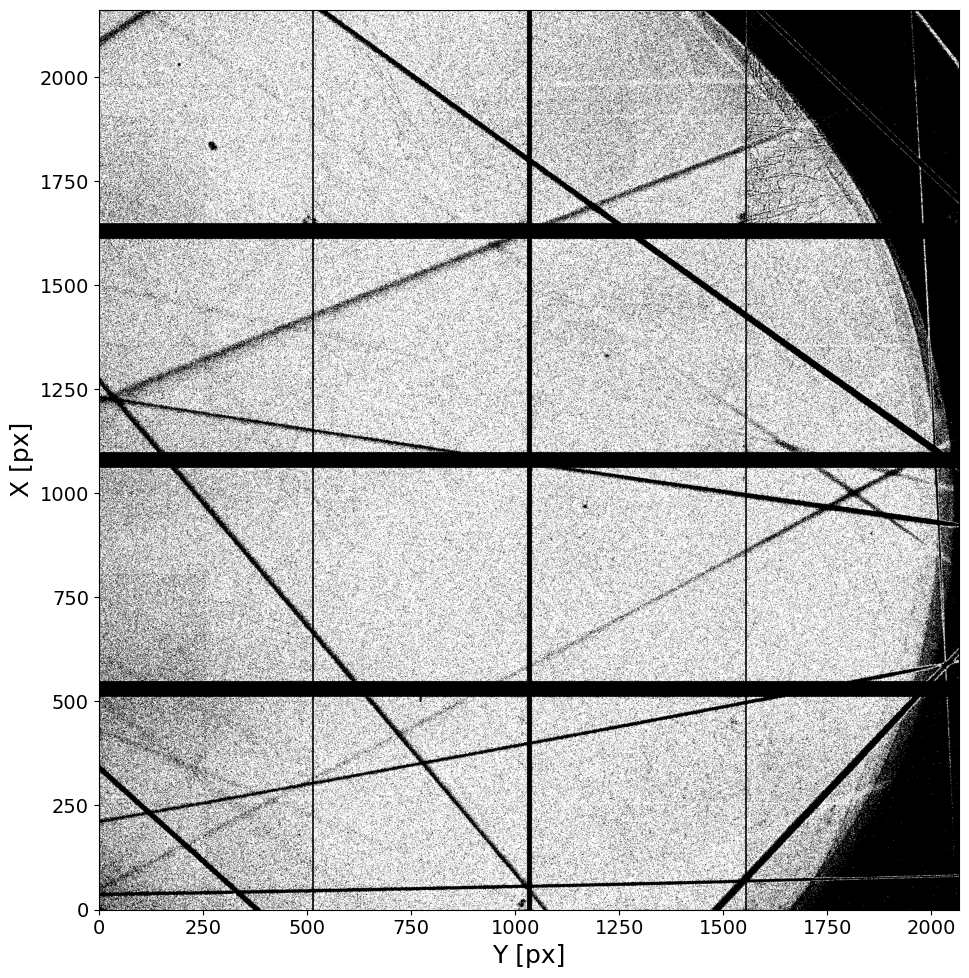

In [18]:
plt.figure(figsize=(10, 10))

plt.imshow(e4mht_mask_si.reshape(Nx, Ny), cmap='gray', origin='lower', alpha=1)
plt.xlabel('Y [px]')
plt.ylabel('X [px]')
plt.tight_layout()
plt.show()

#### Check result on the last part of the scan

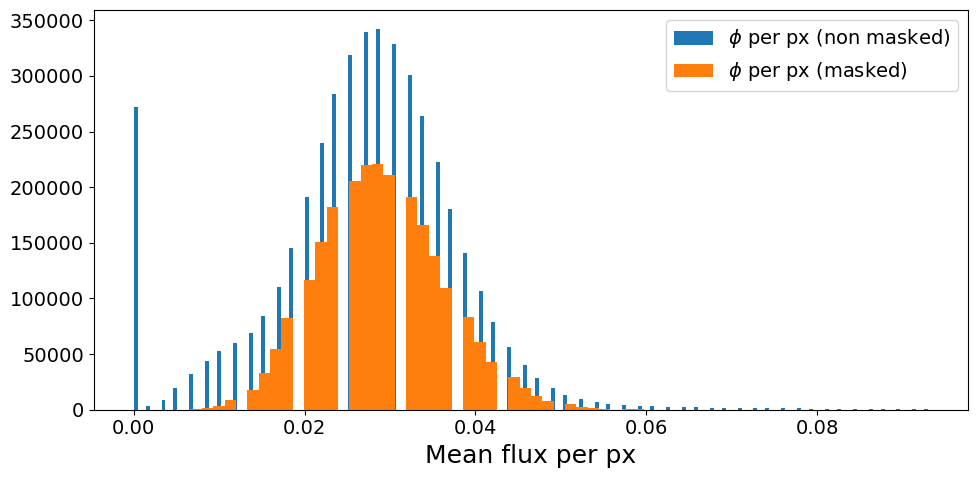

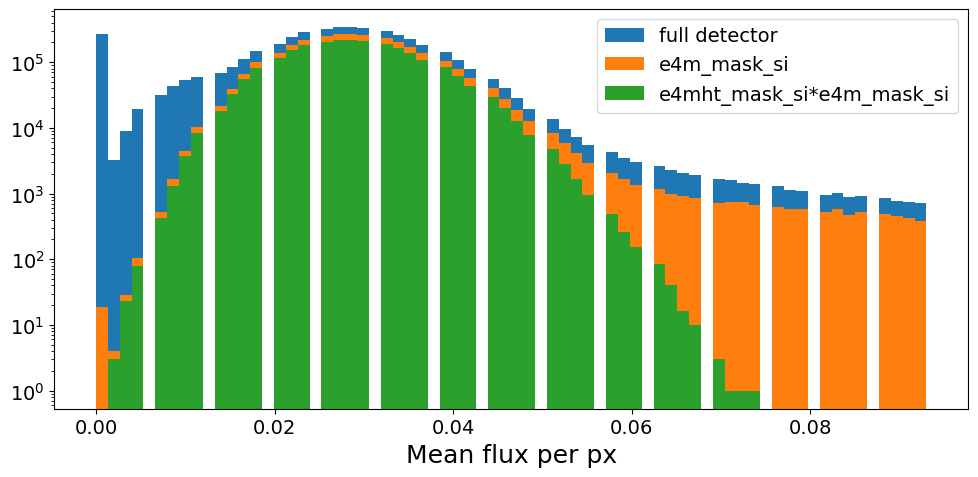

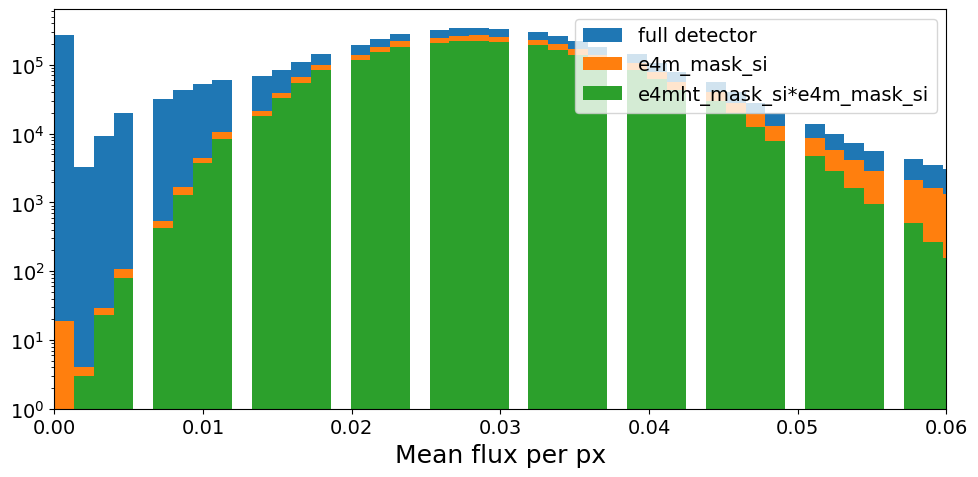

In [22]:
nbins = 70
plt.figure(figsize=(10, 5))
plt.hist(Ip_test, bins=200, range=(0, Ith_high*3), label='$\\phi$ per px (non masked)')
plt.hist(Ip_test[e4m_mask_si*e4mht_mask_si], bins=nbins, range=(0, Ith_high*3), label='$\\phi$ per px (masked)')
#plt.axvline(Ith_high, color='r', label='Ith_high')
#plt.axvline(Ith_low, color='g', label='Ith_low')
plt.xlabel('Mean flux per px')
plt.legend()
plt.tight_layout(); plt.show()

plt.figure(figsize=(10, 5))
plt.hist(Ip_test,                      bins=nbins, range=(0, Ith_high*3), label='full detector')
plt.hist(Ip_test[e4m_mask_si],            bins=nbins, range=(0, Ith_high*3), label='e4m_mask_si')
plt.hist(Ip_test[e4m_mask_si*e4mht_mask_si], bins=nbins, range=(0, Ith_high*3), label='e4mht_mask_si*e4m_mask_si')
#plt.axvline(Ith_high, color='r', label='Ith_high')
#plt.axvline(Ith_low, color='g', label='Ith_low')
plt.yscale('log')
plt.xlabel('Mean flux per px')
plt.legend()
plt.tight_layout(); plt.show()

plt.figure(figsize=(10, 5))
plt.hist(Ip_test,                      bins=nbins, range=(0, Ith_high*3), label='full detector')
plt.hist(Ip_test[e4m_mask_si],            bins=nbins, range=(0, Ith_high*3), label='e4m_mask_si')
plt.hist(Ip_test[e4m_mask_si*e4mht_mask_si], bins=nbins, range=(0, Ith_high*3), label='e4mht_mask_si*e4m_mask_si')
#plt.axvline(Ith_high, color='r', label='Ith_high')
#plt.axvline(Ith_low, color='g', label='Ith_low')
plt.yscale('log')
plt.xlabel('Mean flux per px')
plt.legend()
plt.xlim(0, 0.06)
plt.ylim(1)
plt.tight_layout(); plt.show()

### Load again data this time masked for kossel lines

In [27]:
###################
load_mask = e4m_mask*e4m_htmask*e4mht_mask_si*mask_geom
###################
e4m_data = ID10.load_sparse_e4m(RAW_folder, sample_name, Ndataset, Nscan, Nfi=Nfi, Nff=Nff, load_mask=None, n_jobs=50,)

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/646 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/646 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/646 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/646 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/646 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00005.h5 (6/646 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00006.h5 (7/646 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00007.h5 (8/646 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00008.h5 (9/646 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00009.h5 (10/646 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00010.h5 (11/646 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00011.h5 (12/646 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00012.h5 (13/646 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00013.h5 (14/646 loops)
	 -> loading file eiger4m_v2_spa

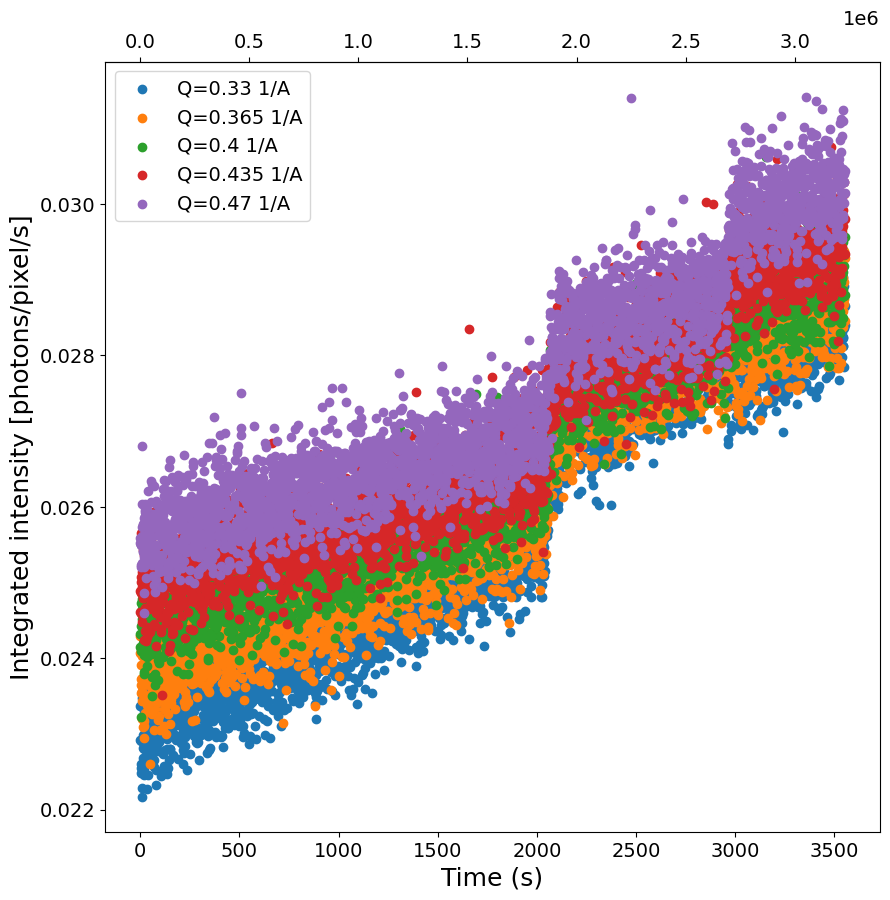

In [58]:
####################
Lbin = 1000
Nstep = 1000
Nfi = None
Nff = None

mask = e4m_mask*e4m_htmask*e4mht_mask_si*mask_geom
####################

plt.figure(figsize=(10, 10))
for i in list(Qmask.keys()):
    t_It, It = XPCS.get_It(e4m_data, itime, Lbin=Lbin, Nstep=Nstep, Nfi=Nfi, Nff=Nff, mask=mask*Qmask[i])
    plt.scatter(t_It, It, label = 'Q='+ str(i) + ' 1/A')
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
#plt.xscale('log')
plt.legend()
plt.show()

### Intensity analysis

In [22]:
####################
Lbin = 1000
Nstep = 1000
mask = None
Nfi = None
Nff = None
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep, Nfi=Nfi, Nff=Nff)
np.savez(It_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_It=t_It, It=It)

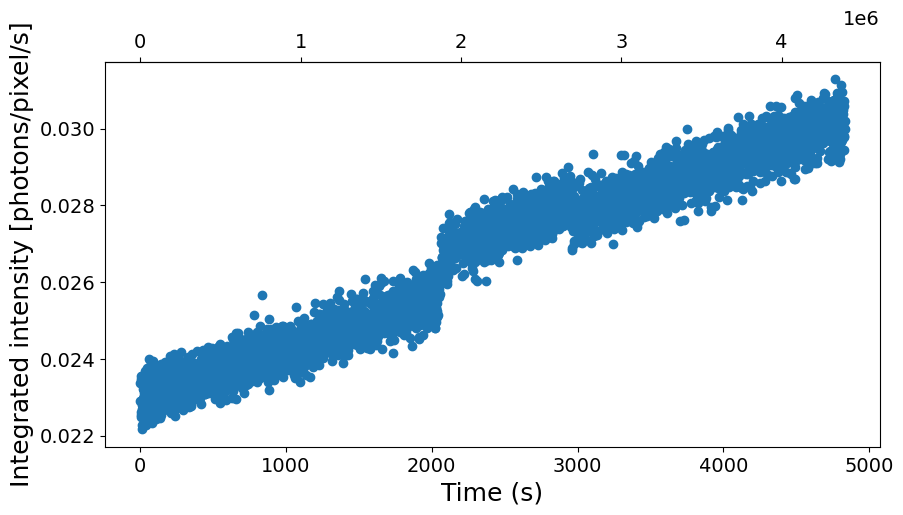

In [23]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
#plt.xscale('log')
plt.show()

### Linear correlation 4 tests

In [17]:
###################
Nfi = None
Nff = None
Lbin = 1000
bin2dense = True
mask = None
###################
if Lbin is None: Lbin=1

G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=bin2dense)

Loading frames ...
Done! (elapsed time = 0.0 s)
Binning frames (Lbin = 1000, using MKL library) ...
Done! (elapsed time = 0.29 s)
	 | 4394 frames X 175127 pixels
	 | memory usage (np.array @ float32) = 2.867 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 2.85 s)
	 | 4394 X 4394 squared matrix
	 | memory usage (np.array @ float32) = 0.072 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 0.15 s)



In [18]:
############################
t1, t2 = 0, 2000
vmin, vmax = 1.0, 1.07
############################
#XPCS.plot_G2t(G2t, vmin, vmax, itime*Lbin, t1=t1, t2=t2, sigma_filter=None)

In [19]:
################
Nbunch = 1
################

NfXbunch = int(G2t.shape[0]/Nbunch)
t_g2, g2, dg2, t_mt, g2_mt, dg2_mt = {}, {}, {}, {}, {}, {}
for n in range(Nbunch):
    if Nfi is None: Nfi = 0
    t_bunch = Nfi*itime + round(itime*Lbin*NfXbunch*(n+1/2),1)

    if Nbunch!=1: t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t[NfXbunch*n:NfXbunch*(n+1), NfXbunch*n:NfXbunch*(n+1)]))
    else:         t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t))
    t_mt[t_bunch], g2_mt[t_bunch], dg2_mt[t_bunch] = XPCS.get_g2mt_fromling2(itime*Lbin, g2[t_bunch],dg2[t_bunch])   


Computing g2 (using cython code)...
1.6574416756629944 1.6545543135941916
1.0702590942382812 1.0702590707074364
Done! (elapsed time = 0.01 s)



/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


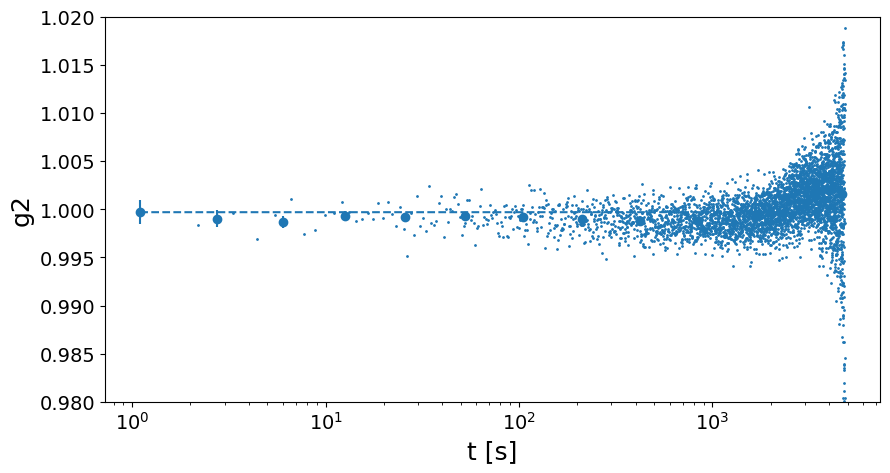

Parameters([('tau', <Parameter 'tau', value=np.float64(120.92435030413799), bounds=[0:1000000.0]>), ('beta', <Parameter 'beta', value=np.float64(8.955108887691182e-13), bounds=[0:2]>), ('c', <Parameter 'c', value=np.float64(6.120233345868421e-05), bounds=[0:1]>), ('y0', <Parameter 'y0', value=np.float64(0.9996793533310334), bounds=[0:2]>)])

Exception ignored in: <function ResourceTracker.__del__ at 0x7f34df62bc40>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7fbf8d033c40>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", li

In [24]:
##################
t1_fit = 0
t2_fit = 1e100
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=1000, min=0, max=1e6)
params.add('beta', value=1, min=0, max=2)
params.add('c', value=.0725, min=0, max=1)
params.add('y0', value=1, min=0, max=2)
#params.add('y0', value=1.003, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    plt.scatter(t_g2[k], g2[k], s=1,  c='C'+str(i), label = str(k)+'s')
    plt.errorbar(t_mt[k], g2_mt[k], yerr = dg2_mt[k],fmt = 'o', c='C'+str(i), label=str(k)+'s')

    x = t_g2[k] [(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    y = g2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    dy = dg2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    fit = model.fit(y, params, t=x, method='least_squares', weights=1/dy)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]


    x = np.arange(np.min(t_g2[k]), np.max(t_g2[k]), 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y, c='C'+str(i), linestyle='--')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(0.98, 1.02)
#plt.legend()
plt.show()

if Nbunch == 1:
    display(fit.params)
else:
    plt.figure(figsize=(10,5))
    plt.title('tau')
    plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('tau [s]')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('beta')
    plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('beta')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('c')
    plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('c')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('y0')
    plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('y0')
    plt.tight_layout(); plt.show()